In [16]:
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate, CXGate, CPhaseGate, HGate, CRXGate, CRZGate
from qiskit.circuit import Measure, Delay, Parameter, Reset
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendSamplerV2
from qiskit.providers.basic_provider import BasicSimulator


In [17]:
class FakeBackend(BackendV2):
    """Fake fully-connected backend."""

    def __init__(self, num_qubits=3, type=1):
        # Create a fully-connected or nearest-neighbour graph using the rustworkx library, then instantiate a new target

        if type == 1:
            super().__init__(name="Fake fully-connected backend")
            self._graph = rx.generators.complete_graph(num_qubits)  # All-to-all
            self._target = Target(
            "Fake fully-connected backend", num_qubits=num_qubits
        )
        else:
            super().__init__(name="Fake nearest-neighbour backend")
            self._graph = rx.generators.path_graph(num_qubits)     # Nearest-neighbour
            self._target = Target(
            "Fake nearest-neighbour backend", num_qubits=num_qubits
        )

        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        h_props = {}
        #sx_props = {}
        measure_props = {}
        delay_props = {}

        # Add 1q gates
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=0.0, #rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            h_props[qarg] = InstructionProperties(
                error=0.0, #rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            # sx_props[qarg] = InstructionProperties(
            #     error=0.0, #rng.uniform(1e-6, 1e-4),
            #     duration=rng.uniform(1e-8, 9e-7),
            # )
            measure_props[qarg] = InstructionProperties(
                error=0.0, #rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(HGate(), h_props)
        #self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)

        # Add 2q gates

        # CZ Gate
        cz_props = {}
        for root_edge in self._graph.edge_list():
            edge1 = (root_edge[0], root_edge[1])
            edge2 = (root_edge[1], root_edge[0])
            cz_props[edge1] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
            cz_props[edge2] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        #self._target.add_instruction(CZGate(), cz_props)


        # CX Gate
        cx_props = {}
        for root_edge in self._graph.edge_list():
            edge1 = (root_edge[0], root_edge[1])
            edge2 = (root_edge[1], root_edge[0])
            cx_props[edge1] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
            cx_props[edge2] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        self._target.add_instruction(CXGate(), cx_props)

        # CRX Gate
        crx_props = {}
        for root_edge in self._graph.edge_list():
            edge1 = (root_edge[0], root_edge[1])
            edge2 = (root_edge[1], root_edge[0])
            crx_props[edge1] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
            crx_props[edge2] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        #self._target.add_instruction(CRXGate(Parameter("theta")), crx_props)

        # CRZ Gate
        crz_props = {}
        for root_edge in self._graph.edge_list():
            edge1 = (root_edge[0], root_edge[1])
            edge2 = (root_edge[1], root_edge[0])
            crz_props[edge1] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
            crz_props[edge2] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        #self._target.add_instruction(CRZGate(Parameter("theta")), crz_props)

        # CP Gate
        cp_props = {}
        for root_edge in self._graph.edge_list():
            edge1 = (root_edge[0], root_edge[1])
            edge2 = (root_edge[1], root_edge[0])
            cx_props[edge1] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
            cx_props[edge2] = InstructionProperties(
                error=0.0, #rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        self._target.add_instruction(CPhaseGate(Parameter("theta")), cp_props)

        self.sim = BasicSimulator()

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @property
    def graph(self):
        return self._graph

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        job = self.sim.run(circuit, **kwargs)
        return job

In [18]:
def ncz(qc: QuantumCircuit, n: int, rot: float, had: bool):
    if n == 2:
        if had:
            qc.h(2)
        qc.cp(rot, 1, 2)
        qc.cx(0, 1)
        qc.cx(1, 0)
        qc.cp(-rot, 1, 2)
        qc.cx(0, 1)
        qc.cp(rot, 1, 2)
        if had:
            qc.h(2)
    else:
        if had:
            qc.h(n)
        qc.cp(rot, n-1, n)
        ncz(qc, n - 1, np.pi / 2, True)
        qc.cp(-rot, n-1, n)
        ncz(qc, n - 1, np.pi / 2, True)
        qc.swap(n-1, n)
        ncz(qc, n - 1, rot / 2, False)
        qc.swap(n-1, n)
        if had:
            qc.h(n)

def set_element_qiskit(qc: QuantumCircuit, element: int, n: int):
    binary_string =  bin(element).removeprefix('0b')
    while len(binary_string) < n:
        binary_string = '0' + binary_string
    if '0' not in binary_string:
        return
    binary_string = reversed(binary_string)
    for idx, binary in enumerate(binary_string):
        if binary == str(0):
            qc.x(idx)

def grover(qc: QuantumCircuit, n: int, element: int):
    if element >= np.pow(2, n):
        print('Element does not fall into the range [0, 2^n - 1]')
        return
    qc.h(slice(0, n))

    num_iterations = 1 # int(np.floor((np.pi / 4) * np.sqrt(np.pow(2, n))))

    for _ in range(num_iterations):
        set_element_qiskit(qc, element, n)
        ncz(qc, n - 1, np.pi / 2, False)
        qc.swap(0, 1)
        set_element_qiskit(qc, element, n)
        qc.h(slice(0, n))
        qc.x(slice(0, n))
        ncz(qc, n - 1, np.pi / 2, False)
        qc.swap(0, 1)
        qc.x(slice(0, n))
        qc.h(slice(0, n))

def grover_mcx(qc: QuantumCircuit, n: int, element: int):
    if element >= np.pow(2, n):
        print('Element does not fall into the range [0, 2^n - 1]')
        return
    qc.h(slice(0, n))

    num_iterations = 1 # int(np.floor((np.pi / 4) * np.sqrt(np.pow(2, n))))

    for _ in range(num_iterations):
        set_element_qiskit(qc, element, n)
        qc.h(n-1)
        qc.mcx([x for x in range(n-1)],n-1)
        qc.h(n-1)
        set_element_qiskit(qc, element, n)
        qc.h(slice(0, n))
        qc.x(slice(0, n))
        qc.h(n-1)
        qc.mcx([x for x in range(n-1)],n-1)
        qc.h(n-1)
        qc.x(slice(0, n))
        qc.h(slice(0, n))

In [19]:
backend_fc = FakeBackend(20, 1)
backend_nn = FakeBackend(20, 2)

target_fc = backend_fc.target
coupling_map_backend_fc = target_fc.build_coupling_map()
target_nn = backend_nn.target
coupling_map_backend_nn = target_nn.build_coupling_map()

line_colors_fc = ["#adaaab" for edge in coupling_map_backend_fc.get_edges()]
line_colors_nn = ["#adaaab" for edge in coupling_map_backend_nn.get_edges()]

Fake fully-connected backend
['x', 'h', 'rz', 'measure', 'reset', 'delay', 'cx', 'cp']
Fake nearest-neighbour backend
['x', 'h', 'rz', 'measure', 'reset', 'delay', 'cx', 'cp']


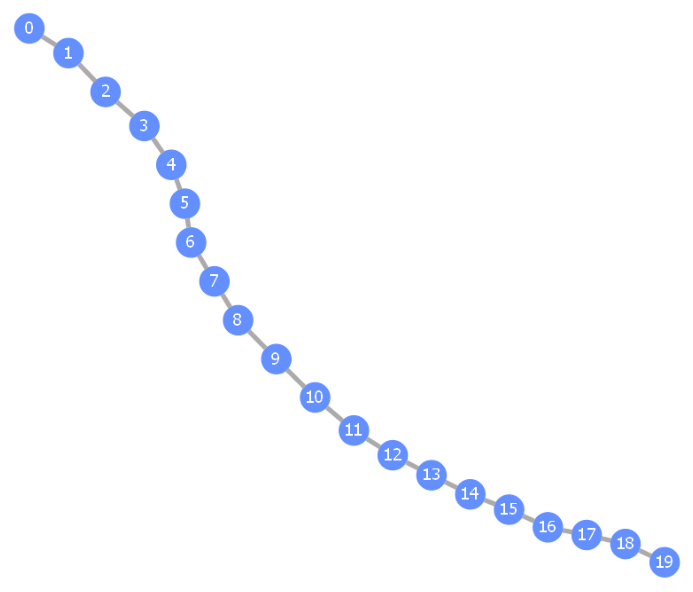

In [20]:
print(backend_fc.name)
print(backend_fc.operation_names)
plot_gate_map(
    backend_fc,
    line_color=line_colors_fc,
)
print(backend_nn.name)
print(backend_nn.operation_names)
plot_gate_map(
    backend_nn,
    line_color=line_colors_nn,
)

In [21]:
num_qubits = 5
qc1 = QuantumCircuit(num_qubits)
grover(qc1, num_qubits, 1)
qc1.measure_all()

print(qc1.count_ops())
#qc1.draw(output='mpl')

OrderedDict({'cp': 70, 'cx': 54, 'h': 47, 'x': 18, 'swap': 18, 'measure': 5, 'barrier': 1})


In [22]:
pm1 = generate_preset_pass_manager(optimization_level=1, backend=backend_nn)
transpiled_qc1 = pm1.run(qc1)
print(transpiled_qc1.count_ops())

#transpiled_qc1.draw("mpl", idle_wires=False)

OrderedDict({'cx': 108, 'cp': 70, 'h': 47, 'x': 18, 'measure': 5, 'barrier': 1})


In [23]:
num_qubits = 7
qc2 = QuantumCircuit(num_qubits)
grover_mcx(qc2, num_qubits, 1)
qc2.measure_all()

print(qc2.count_ops())
#qc2.draw(output='mpl')

OrderedDict({'x': 26, 'h': 25, 'measure': 7, 'mcx': 2, 'barrier': 1})


In [24]:
pm2 = generate_preset_pass_manager(optimization_level=3, backend=backend_fc) # IBM transpiler on fully-connected backend
transpiled_qc2 = pm2.run(qc2)
print(transpiled_qc2.count_ops())

#transpiled_qc2.draw("mpl", idle_wires=False)

OrderedDict({'rz': 372, 'cx': 278, 'h': 96, 'x': 21, 'measure': 7, 'barrier': 1})


In [25]:
pm3 = generate_preset_pass_manager(optimization_level=3, backend=backend_nn) # IBM transpiler on nearest-neighbour backend
transpiled_qc3 = pm3.run(qc2)
print(transpiled_qc3.count_ops())

#transpiled_qc2.draw("mpl", idle_wires=False)

OrderedDict({'rz': 2224, 'cx': 811, 'h': 668, 'x': 12, 'measure': 7, 'barrier': 1})


In [26]:
sampler = BackendSamplerV2(backend=backend_nn)

>>> Job ID: 76f20f53-97c9-49f5-80f0-82b176a3ea2d
>>> Job Status: JobStatus.RUNNING


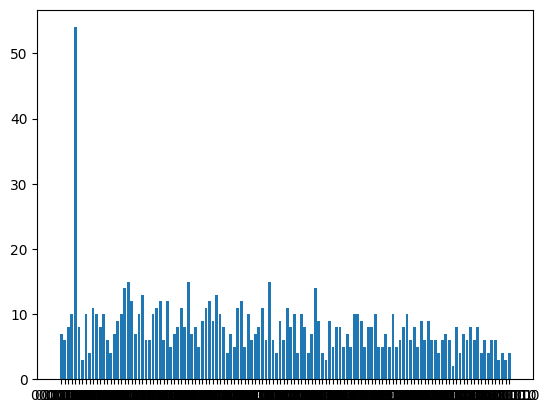

In [27]:
job = sampler.run([(transpiled_qc3)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]
counts = pub_result.data.meas.get_counts()
plt.bar(range(len(counts)), list(counts.values()))
plt.xticks(range(len(counts)), list(counts.keys()))
plt.show()

In [28]:
gates_nn_our = []
gates_nn_our_2q = []
gates_nn = []
gates_nn_2q = []
gates_fc = []
gates_fc_2q = []
for num_qubits in range(3, 11):
    # Nearest-neighbor our transpiler
    qc_nn_our = QuantumCircuit(num_qubits)
    grover(qc_nn_our, num_qubits, 1)
    qc_nn_our.measure_all()

    pm_nn_our = generate_preset_pass_manager(optimization_level=1, backend=backend_nn)
    transpiled_qc_nn_our = pm_nn_our.run(qc_nn_our)
    count_ops_nn_our = transpiled_qc_nn_our.count_ops()
    gates_nn_our.append(sum(count_ops_nn_our.values()))
    gates_nn_our_2q.append(count_ops_nn_our['cx'])

    # Nearest-neighbor ibm transpiler
    qc_nn = QuantumCircuit(num_qubits)
    grover_mcx(qc_nn, num_qubits, 1)
    qc_nn.measure_all()

    pm_nn = generate_preset_pass_manager(optimization_level=3, backend=backend_nn)
    transpiled_qc_nn = pm_nn.run(qc_nn)
    count_ops_nn = transpiled_qc_nn.count_ops()
    gates_nn.append(sum(count_ops_nn.values()))
    gates_nn_2q.append(count_ops_nn['cx'])

    # Fully-connected
    qc_fc = QuantumCircuit(num_qubits)
    grover_mcx(qc_fc, num_qubits, 1)
    qc_fc.measure_all()

    pm_fc = generate_preset_pass_manager(optimization_level=3, backend=backend_fc)
    transpiled_qc_fc = pm_fc.run(qc_fc)
    count_ops_fc = transpiled_qc_fc.count_ops()
    gates_fc.append(sum(count_ops_fc.values()))
    gates_fc_2q.append(count_ops_fc['cx'])

In [29]:
print(gates_nn_our)
print(gates_nn_our_2q)
print(gates_nn)
print(gates_nn_2q)
print(gates_fc)
print(gates_fc_2q)

[41, 97, 249, 689, 1993, 5889, 17561, 52561]
[12, 36, 108, 324, 972, 2916, 8748, 26244]
[106, 424, 707, 2429, 3768, 5545, 8727, 14143]
[19, 55, 187, 440, 806, 1339, 1818, 2330]
[49, 89, 213, 528, 775, 1095, 1625, 2235]
[12, 28, 72, 166, 278, 440, 648, 888]


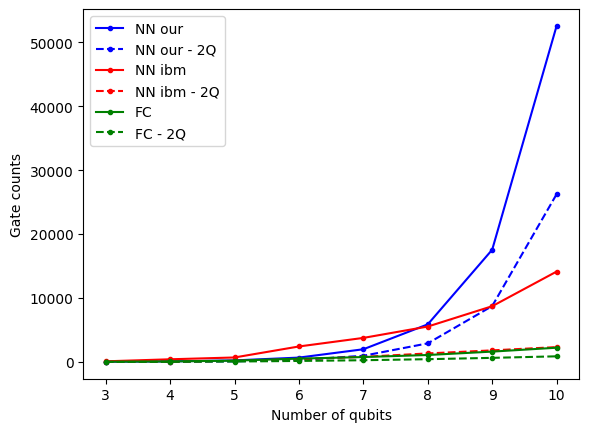

In [30]:
fig, ax = plt.subplots()
x = [x for x in range(3, 11)]
ax.plot(x, gates_nn_our, '.-b', label="NN our")
ax.plot(x, gates_nn_our_2q, '.--b', label="NN our - 2Q")
ax.plot(x, gates_nn, '.-r', label="NN ibm")
ax.plot(x, gates_nn_2q, '.--r', label="NN ibm - 2Q")
ax.plot(x, gates_fc, '.-g', label="FC")
ax.plot(x, gates_fc_2q, '.--g', label="FC - 2Q")
ax.legend()
plt.xlabel("Number of qubits")
plt.xticks(x)
plt.ylabel("Gate counts")
plt.show()